# Surface and bottom boundary layer dynamics

In particle tracking simulations, it may be desirable to apply corrections near to model boundaries to account for physical processes that aren't resolved in the gridded input data that is used to drive the model. Examples include near to the surface and bottom boundaries, where the gridded field often ends a half-cell width away from the physical boundary. If a particle sits between one of these points and the physical boundary, one can extrapolate the field to the particle's position. However, this may be inconsistent with the model's boundary conditions. For example, in the bottom boundary layer, empicial studies have shown the velocity field follows a logarithmic profile near to the boundary, which can be modelled using the expression:
$$
\begin{equation}
\bf{u}(z) = \frac{\bf{u}_{_{\text{*}}}}{\kappa} ln\left(\frac{z}{z_{\text{0}}}\right)
\end{equation}
$$
where $\bf{u}_{\text{z}}$ is the velocity at height $z$ above the sea floor, $\bf{u}_{\text{*}}$ is the friction velocity, $\kappa$ is the von Karman constant, and $z_{\text{0}}$ is the roughness height. By extrapolating the velocity field down to the bed, one will tend to overestimate the near bed velocity field.

In PyLag, particle objects have two properties which are used to signify whether the particle resides in the surface or bottom boundary layers. These are:

* `in_surface_boundary_layer` - If this attribute is set to `True`, the particle is in the surface boundary layer.
* `in_bottom_boundary_layer` - If this attribute is set to `True`, the particle is in the bottom boundary layer.

These two properties are continuously updated as particles move in and out of the two layers, and they can be used to signify whether a particle needs special treatment near to the boundary.

PyLag support for handling boundary layer dynamics is still under development. Presently, there is support for applying a logarithmic correction to the near bed velocity field in particle tracking simulations that use FVCOM driving data. This option is turned on and off using the run configuration file and the following parameters, which should be set in the configuration file section titled `OCEAN_DATA`:

* `use_near_bottom_log_velocity_profile` - If this attribute is set to `True`, the Law of the Wall is applied to the velocity field near the bottom boundary.
* `z0` - The roughness length in meters.

In the run configuration file, this appears as:

```python
[OCEAN_DATA]

# Apply the Law of the Wall to the velocity field near the bottom boundary
use_near_bottom_log_velocity_profile = False

# The roughness height in meters (will vary depending on the bottom type, and from simulation to simulation)
z0 = 4.e-4 # Example value that approximates unrippled sand 
```

For now, a bed roughness height that is constant across the full domain must be used. In the future, we may include the option to specify a spatially varying roughness length scale.

## Example: Correcting the near bottom velocity field using FVCOM data for the Tamar Esturary

This capability is demonstrated using the [FVCOM Tamara Estuary setup](../../examples/fvcom_forward_tracking.ipynb), as described in the [examples](../../examples/index.rst) section of PyLag's documentation. Here, we don't perform a full simulation using PyLag. Rather, we create an object of type `FVCOMDataReader`, which is configured to read in FVCOM data, and use it to compute the velocity profile at a point in space corresponding to the L4 time series site in the Western English Channel. The result of applying the logarithmic profile correction is contrasted with the result of extrapolating the field down to the sea floor.

### Creating a grid metrics file

In this example, we will use the grid metrics file that is supplied with PyLag's example [datasets](https://drive.google.com/open?id=15UX7Y9JnuLpnPAz700mzmzd917nTClxR). As in the tutorial examples, we assume this file has been saved in a directory called `data/pylag_doc`, which sits in the home directory.

In [1]:
import os
import pathlib

from pylag.grid_metrics import create_fvcom_grid_metrics_file


# Root directory for PyLag example input files
home_dir = os.environ['HOME']
data_dir=f'{home_dir}/data/pylag_doc'

# An example FVCOM output file
fvcom_file_name = f'{data_dir}/fvcom_tamar_estuary_0001.nc'

# The file listing the location of open boundary nodes
# NB - if this is omitted, the model treats open boundaries
# as land boundaries.
obc_file_name = f'{data_dir}/fvcom_tamar_estuary_obc.dat'

# Create example directory
example_dir = f"{pathlib.Path.cwd()}/bdy_dynamics"
pathlib.Path(example_dir).mkdir(parents=True, exist_ok=True)

# The name of the output file
grid_metrics_file_name = f'{example_dir}/grid_metrics.nc'

# Generate the file
create_fvcom_grid_metrics_file(fvcom_file_name, obc_file_name=obc_file_name,
                               grid_metrics_file_name=grid_metrics_file_name)

Creating FVCOM grid metrics file /users/modellers/jcl/code/git/PyLag/PyLag/doc/source/documentation/cookbook/bdy_dynamics/grid_metrics.nc

Calculating element areas ... done
Grid has 45 nodes on the open boundary


We now create a run configuration object which specifies that we are working with the FVCOM tamar estuary data, and that we wish to correct the velocity near to the bed.

In [2]:
import configparser
import datetime

from pylag.fvcom_data_reader import FVCOMDataReader
from pylag.mediator import SerialMediator


# Create config
config = configparser.ConfigParser()
config.add_section('SIMULATION')
config.set('SIMULATION', 'coordinate_system', 'geographic')
config.add_section('OCEAN_DATA')
config.set('OCEAN_DATA', 'name', 'FVCOM')
config.set('OCEAN_DATA', 'data_dir', f'{data_dir}')
config.set('OCEAN_DATA', 'grid_metrics_file', f'{grid_metrics_file_name}')
config.set('OCEAN_DATA', 'data_file_stem', 'fvcom_tamar_estuary_0')
config.set('OCEAN_DATA', 'rounding_interval', '3600')
config.set('OCEAN_DATA', 'Kz_method', 'none')
config.set('OCEAN_DATA', 'Ah_method', 'none')
config.set('OCEAN_DATA', 'has_is_wet', 'True')

# Extra options to help the config pass PyLag's internal checks
config.add_section('NUMERICS')
config.set('NUMERICS', 'num_method', 'test')
config.set('NUMERICS', 'time_step_adv', '1')

# Set date limits. These carry no special meaning here. PyLag uses these
# limits to ensure the supplied input data covers the period we are interested
# in. We must simply specify a time between these limits when creating the
# vertical profile.
datetime_start = datetime.datetime(2020,5,2,3)
datetime_end = datetime.datetime(2020,5,2,18)

To reconstruct a velocity profile, we use PyLag's Particle class to create a particle object. We then vary the position of this particle, and use PyLag's FVCOMDataReader to compute the velocity at the particle's position. We use PyLag's Python API to accomplish this.

In [3]:
import numpy as np

from pylag.particle_cpp_wrapper import ParticleSmartPtr
from pylag.data_types_python import DTYPE_FLOAT


def compute_current_profile(apply_log_correction):
    """ Generate the velocity profile
    
    Parameters
    ----------
    apply_log_correction: bool
     Boolean indicating whether the log correction should be applied or not. True or False

    Returns
    -------
    depth_arr: NetCDF array
        Depth array
        
    speed_arr: NetCDF array
        Current speed array
    """
    if apply_log_correction:
        config.set('OCEAN_DATA', 'apply_near_bottom_log_velocity_profile', 'True')
        config.set('OCEAN_DATA', 'z0', '1.e-4')
    else:
        config.set('OCEAN_DATA', 'apply_near_bottom_log_velocity_profile', 'False')

    # Create a mediator object, which controls file access
    mediator = SerialMediator(config, 'ocean', datetime_start, datetime_end)
    
    # Create the FVCOM data reader
    data_reader = FVCOMDataReader(config, mediator)
    
    # Set location to Station L4. Internally, PyLag stored particle positions
    # in radians, so we convert these here. NB - this is different to how positions
    # are speficied in the initial positions file.
    x1 = -4.17 * np.radians(1)
    x2 = 50.25 * np.radians(1)
    
    # Create a particle object
    particle = ParticleSmartPtr(x1=x1, x2=x2)
    
    # Determine the host hoizontal element - needed for interpolating the velocity field
    flag = data_reader.find_host_using_global_search_wrapper(particle)
    
    if flag != 0:
        raise RuntimeError('Failed to locate the particle')
    
    # Define the time at which we want to compute the velocity profile
    datetime_now = datetime.datetime(2020,5,2,12)
    time = (datetime_now - datetime_start).total_seconds()
    
    # Read data for the current time
    data_reader.read_data(time)
    
    # Compute the water depth and the sea surface height at the particle's spatiotemporal coordinates
    h = data_reader.get_zmin_wrapper(time, particle)
    zeta = data_reader.get_zmax_wrapper(time, particle)
    
    # Define a vertical grid of points between h and zeta
    n_depths = 1000
    depth_arr = np.linspace(h, zeta, n_depths)
    
    # Create a profile of the current speed
    current_speed_arr = np.empty_like(depth_arr)
    for i in range(n_depths):
    
        # Update the depth of the particle
        particle.x3 = depth_arr[i]
    
        # Set vertical interpolation coefficients
        if data_reader.set_vertical_grid_vars_wrapper(time, particle) != 0:
            raise RuntimeError('Failed to set vertical grid variables')

        # Compute the velocity at the particle's spatiotemporal coordinates
        vel = np.empty(3, dtype=DTYPE_FLOAT)
        data_reader.get_velocity_wrapper(time, particle, vel)
    
        # Compute speed from the horizontal component only
        current_speed_arr[i] = np.sqrt(vel[0]**2 + vel[1]**2)

    return depth_arr, current_speed_arr, h, zeta

# No correction
z_not_corrected, curr_not_corrected, h, zeta = compute_current_profile(False)

# With correction
z_corrected, curr_corrected, _, _ = compute_current_profile(True)

We can now plot the current profile.

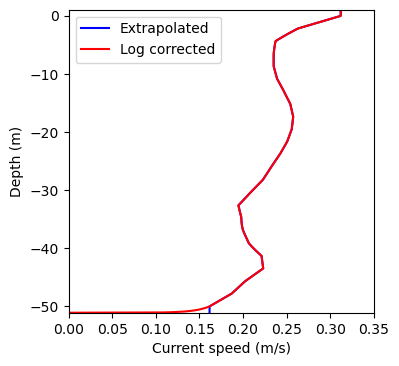

In [4]:
from matplotlib import pyplot as plt

from pylag.processing.plot import create_figure

fs = 10

fig, ax = create_figure(font_size=fs) 
ax.plot(curr_not_corrected, z_not_corrected, c='b', label="Extrapolated")
ax.plot(curr_corrected, z_corrected, c='r', label="Log corrected")
ax.set_xlabel('Current speed (m/s)')
ax.set_ylabel('Depth (m)')
ax.legend(prop={'size': fs})
_ = ax.set_xlim([0, 0.35])
_ = ax.set_ylim([h, zeta])

The impact of the correction is just visible toward the bottom of the water column. The extrapolated surface current near to the surface is evident in both plots.